In [779]:
## Import required libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import copy #you cannot just say a = z because this just means that a is a new reference to z, instead we acually have to copy the contents over from z to a and then we can change a without changing z
import random
import matplotlib.animation as animation
import random
from matplotlib import cm

In [999]:
LIM = 512

FUNC_EVAL_LIM = 375 # Number of iterations
DIM = 2 # Dimension of problem

POP_SIZE = 60 # Population size
BITS = 14 # Number of bits required for 1 dimension of input to problem

S = 1.5 # Selection pressure value

P_CROSSOVER = 0.9722 # Probability of Crossover
P_MUTATION = 0.1 # Probability of Mutation

SELECTION_TYPE = 'Tournament' # 'Simple_roulette', 'SRSWR' , 'Tournament'
BREEDING_TYPE = 'Simple' # 'Simple', 'Cavicchio'
MUTATION_TYPE = 'SA_like' # 'SA_like'

STARTING_T = 0.2278
L_K = 20

BREAKOUT_TOLERENCE = 0.1 # Difference between a solution and the solution 3 back that leads to early breakout

TOURNAMENT_GROUP_SIZE = 20 # Size of group in Tournament Selection

## For Archiving
ARCHIVE_LEN = 25 # Length of Archive
DISS_MIN = 50 # Minimum distance away before can be entered into dissimilar Archive
DISS_SIM = 5 # Minimum distance away before can replace closest element from dissimilar Archive

METHOD = 'Genetic Algorithms'

In [1000]:
## Define eggholder function 
def eggholder(x):
    y = 0
    for i in range(len(x)-1):
        y += -(x[i+1]+47) * math.sin(np.sqrt(abs(x[i+1]+x[i]/2+47))) - x[i] * math.sin(np.sqrt(abs(x[i]-x[i+1]-47)))
    return y 

In [1001]:
## Converts binary string to x value (can be multidimensional)
def binary2decimal(binary):
    x = []
    binary = np.array(binary)
    for i in range(DIM):
        ## Separate into the different dimensions
        bits_list = binary[i*BITS:(i+1)*BITS]
        decimal = 0
        for bit in bits_list:
            ## Use bit shift operator in python so do convertion quickly
            decimal = (decimal << 1) | bit
        ## Bit string only represents integers so convert to decimal number and applying limit
        x.append(decimal/(2**BITS)*2*LIM-LIM)
    return x

In [1002]:
## Calculate objective function values for a population
def ratePop(pop):
    ## A fast method for building up the arrays
    xs = [binary2decimal(pop[i]) for i in range(len(pop))]
    fs = [eggholder(xs[i]) for i in range(len(pop))]
    return xs, fs

In [1003]:
## Create initial random population with given seed
def initialise_random_population(seed = 0):
    np.random.seed(seed)
    random.seed(seed)
    return np.array([np.random.randint(0, 2, DIM * BITS).tolist() for i in range(POP_SIZE)])

In [1004]:
## Returns an array of the rank order
def rank_f(fs): 
    return np.argsort(np.argsort(fs))

## Calculates p_S as Baker
def parent_selection_probs_baker(fs):
    R = rank_f(fs)
    N = len(fs)
    ## As in lecture notes
    p_S = [(S*(N+1-2*R[i]) + 2*(R[i]-1)) / (N*(N-1)) for i in range(len(fs))]
    return np.array(p_S)/sum(p_S)

In [1005]:
## Simple roulette selection scheme
def simple_roulette(pop, p_S):
    ## Choose the indexes of the population array, weighted by p_S, with replacement
    indexes = np.random.choice(len(pop),len(pop),p=p_S)
    selection = []
    ## Append each selected member of population to selection array
    for index in indexes:
        selection.append(pop[index])
    return np.array(selection)
       

## Stochastic Remainder Selection without Replacement
def srswr(pop, p_S):
    selection = []
    pop = np.array(pop)
    p = np.array(p_S) * len(pop)
    ## Append integer part number of each member
    for i in range(len(p)):
        while p[i] >= 1:
            selection.append(pop[i])
            ## Update p
            p[i] -= 1
    ## Renormalise p to sum to 1
    p = p / np.sum(p)
    ## Chose the indexes of the population array, weighted by p, with replacement
    indexes = np.random.choice(len(pop),len(pop) - len(selection), p=p)
    ## Append each selected member of population to selection array
    for index in indexes:
        selection.append(pop[index])
    return np.array(selection)

## Tournament Selection Scheme
def tournament(pop, p_S):
    selection = []
    p = np.array(p_S)
    length = len(pop) # Number of parents
    for i in range(length):
        ## Randomly select group of population
        indexes = np.random.choice(len(pop),TOURNAMENT_GROUP_SIZE, replace = False)
        ## Select best in group
        selection.append(pop[indexes[np.argmax(p[indexes])]])
    return np.array(selection)

In [1006]:
###---------------##
##Breeding Schemes

## One point crossover
def crossover_simple(parents):
	children = []
	## Randomly rearrange order of parents
	random.shuffle(parents)
	## For each pair of parents
	for i in range(0,len(parents),2):
		p1,p2 = parents[i], parents[i+1]
		c1, c2 = p1.copy(), p2.copy() # Copy so no direct changes are made to parents
		## If crossover is meant to occur
		if random.random() < P_CROSSOVER:
			# Select crossover point that is not at end of bit string
			pt = np.random.randint(1, len(p1)-2)
			# Do crossover as in lecture notes
			c1 = np.concatenate((p1[:pt],p2[pt:]))
			c2 = np.concatenate((p2[:pt],p1[pt:]))
		children.append(c1)
		children.append(c2)
	return children

## Two point crossover
def cross_over_cavicchio(parents):
	children = []
	## Randomly rearrange order of parents
	random.shuffle(parents)
	## For each pair of parents
	for i in range(0,len(parents),2):
		p1, p2 = parents[i], parents[i+1]
		c1, c2 = p1.copy(), p2.copy() # Copy so no direct changes are made to parents
		## If crossover is meant to occur
		if random.random() < P_CROSSOVER:
			# Select crossover points that are not at end of bit string
			pt1 = np.random.randint(1, len(p1)-2)
			pt2 = np.random.randint(1, len(p1)-2)
			# Perform crossover as in lecture notes
			if pt1 > pt2:
				c1 = np.concatenate((p2[:pt2],p1[pt2:pt1],p2[pt1:]))
				c2 = np.concatenate((p1[:pt2],p2[pt2:pt1],p1[pt1:]))
			else:  
				c1 = np.concatenate((p1[:pt2],p2[pt2:]))
				c2 = np.concatenate((p2[:pt2],p1[pt2:]))
		children.append(c1)
		children.append(c2)
	return children

###----------------###
##Mutation Scheme
def mutation(children, prob = P_MUTATION):
	length = len(children) * DIM * BITS # Total number of bits in children
	children = np.array(children)
	inter = children.ravel() # Flatten array so can loop through
	## Choose indexes where a mutation should occur, length*P_MUTATION number of mutations will occur
	indexes = np.random.choice(length,int(length*prob), replace = False)
	## Mutate the relevant indexes
	for i in indexes:
		if inter[i] == 0:
			inter[i] = 1
		else:
			inter[i] = 0
	## Return back to required shape
	children = np.array(inter.reshape(POP_SIZE, BITS*DIM))

	## Second method that's slower but more accurate
	# for child in children:
	# 	for i in range(len(child)):
	# 		if random.random() < P_MUTATION:
	# 			if child[i] == 0:
	# 				child[i] = 1
	# 			else: 
	# 				child[i] = 0
	# 		else: pass
	return children

In [1007]:
###------------------###
## Archiving functions 

## Calculate Euclidean distance between 2 arrays
def dist(x_new, x_old):
    diss = 0
    for i in range(len(x_new)):
        diss += (x_new[i] - x_old[i])**2
    return np.sqrt(diss)

## Update both best and dissimilar archives
def update_archive(diss_archive_x, diss_archive_f, best_archive_x, best_archive_f, x, f_curr):
    ## If dissimilar array is len 0, fill 
    if len(diss_archive_x) == 0:
        diss_archive_x.append(x)
        diss_archive_f.append(f_curr)
    ## If array not full, fill if input is dissimilar to everything else
    elif len(diss_archive_x) < ARCHIVE_LEN:
        check_diss = True
        for i in range(len(diss_archive_x)):
            diss = dist(x,diss_archive_x[i])
            if diss < DISS_MIN:
                check_diss = False
        if check_diss:
            diss_archive_x.append(x)
            diss_archive_f.append(f_curr)
    ## If array is full
    else:
        min = np.inf
        check_diss = True
        for i in range(len(diss_archive_x)):
            diss = dist(x, diss_archive_x[i])
            if diss < DISS_MIN:
                check_diss = False
            ## Get most similar x
            if diss < min:
                min = diss
                x_e_index = i
        ## If dissimilar and solution better than worst
        if check_diss & (f_curr < np.max(diss_archive_f)):
            diss_archive_x.append(x)
            diss_archive_f.append(f_curr)
            diss_archive_x.pop(np.argmax(diss_archive_f))
            diss_archive_f.pop(np.argmax(diss_archive_f))
        ## If solution is best so far
        elif (f_curr < np.min(diss_archive_f)):
            diss_archive_x.append(x)
            diss_archive_f.append(f_curr)
            diss_archive_x.pop(x_e_index)
            diss_archive_f.pop(x_e_index)
        ## Or if solution not best but sufficiently similar and better than x_e
        elif ((min<DISS_SIM) & (f_curr < diss_archive_f[x_e_index])):
            diss_archive_x.append(x)
            diss_archive_f.append(f_curr)
            diss_archive_x.pop(x_e_index)
            diss_archive_f.pop(x_e_index)
        else:
            pass
    
    ## If best array not full, fill 
    if len(best_archive_x) < 25:
        best_archive_x.append(x)
        best_archive_f.append(f_curr)
    ## If array is full
    elif f_curr < np.max(best_archive_f):
        best_archive_x.append(x)
        best_archive_f.append(f_curr)
        best_archive_x.pop(np.argmax(best_archive_f))
        best_archive_f.pop(np.argmax(best_archive_f))
    return diss_archive_x, diss_archive_f, best_archive_x, best_archive_f

In [1008]:
def ga(seed = 0, archive = False):
    evals = 0
    ## Initialise first population
    pop = initialise_random_population(seed = seed)

    ## Calculate objective function value for each member of the population
    xs, fs = ratePop(pop)
    ## Store best solution
    bestx, bestf, best_avg_fitness = xs[np.argmin(fs)], np.min(fs), np.mean(fs)
    
    ## Archiving
    best_archive_x = []; best_archive_f = []; diss_archive_x = []; diss_archive_f = []
    if archive:
        for i in range(len(xs)):
            diss_archive_x, diss_archive_f, best_archive_x, best_archive_f = update_archive(diss_archive_x, diss_archive_f, best_archive_x, best_archive_f, xs[i], fs[i])
    
    temp_prob = STARTING_T
    ## Create storage arrays
    x_hist = []; f_hist = []; x_sol = [bestx]; f_sol = [bestf]
    while evals < FUNC_EVAL_LIM:
        # if evals % 500 == 0:
        #     print('Current iteration - {}'.format(evals))
        
        ## Iterate P_M every L_K iterations for SA-like mutation scheme
        if evals % L_K == 0:
            temp_prob *= 0.85

        ## Calculate p_S as Baker suggests
        p_S = parent_selection_probs_baker(fs)

        ## SELECT PARENTS
        if SELECTION_TYPE == 'Simple_roulette':
            parents = simple_roulette(pop,p_S)
        elif SELECTION_TYPE == 'SRSWR':
            parents = srswr(pop, p_S)
        elif SELECTION_TYPE == 'Tournament':
            parents = tournament(pop, p_S)
        else: 
            print('Please select valid selection method')
            break    
        
        ## BREED
        if BREEDING_TYPE == 'Simple':
            children = crossover_simple(parents)
        elif BREEDING_TYPE == 'Cavicchio':
            children = cross_over_cavicchio(parents)
        else:
            print('Please select valid breeding method')
            break  
        
        ## MUTATION
        if MUTATION_TYPE == 'Simple':
            children = mutation(children)
        elif MUTATION_TYPE == 'SA_like':
            children = mutation(children, prob = temp_prob)

        ##Update population
        pop = children

        ## Calculate objective function for new population and calculate performance measures
        xs, fs = ratePop(pop) 
        x, f, avg_fitness = xs[np.argmin(fs)], np.min(fs), np.mean(fs)

        ## Archiving
        if archive:
            for i in range(len(xs)):
                diss_archive_x, diss_archive_f, best_archive_x, best_archive_f = update_archive(diss_archive_x, diss_archive_f, best_archive_x, best_archive_f, xs[i], fs[i])
        
        ## Update if new best solution
        if f < bestf:
            bestx = x
            bestf = f
            x_sol.append(x)
            f_sol.append(f)
        if avg_fitness < best_avg_fitness:
            best_avg_fitness = avg_fitness

        ## Update history records
        x_hist.append(x)
        f_hist.append(f)
        evals += 1

        ## Early breakout logic
        # if len(f_sol) >= 3:
        #     if np.absolute(f_sol[-3] - f_sol[-1]) <= BREAKOUT_TOLERENCE: # comparing the fitness of the current best member to the best member 50 generations ago
        #         # print('Breaking out at iteration {}'.format(evals))
        #         break
    return bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, xs

In [1026]:
# %%timeit
FUNC_EVAL_LIM = 25
DIM = 2
bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, xs = ga(seed = 20, archive = True)

In [1024]:
bestf

-959.4282706210633

In [902]:
def calcEval(num=4000):
    x1 = np.linspace(-LIM-1, LIM+1, num)
    x2 = np.linspace(-LIM-1, LIM+1, num)
    xx1, xx2 = np.meshgrid(x1, x2)

    f_eval = np.zeros([len(xx1), len(xx2)])
    
    for i in range(len(x1)):
        for j in range(len(x2)):
            f_eval[i][j] = eggholder([x1[i], x2[j]])
    return f_eval, num
    
def plot_walk(f_eval, points, num, colour = 'C0'):
    x1 = np.linspace(-LIM-1, LIM+1, num)
    x2 = np.linspace(-LIM-1, LIM+1, num)
    xx1, xx2 = np.meshgrid(x1, x2)

    fig, ax = plt.subplots(constrained_layout=True)
    CS = ax.contourf(xx1, xx2, f_eval, 20, cmap=cm.plasma)

    ax.set_xlabel('$x_1$', fontsize=18)
    ax.set_ylabel('$x_2$', fontsize=18)

    cbar = fig.colorbar(CS)
    cbar.ax.set_ylabel('$f(\mathbf{x})$')
    
    ax.plot(np.array(points)[:,0], np.array(points)[:,1], c=colour)
    plt.show()
    pass

def plot_points(f_eval, points, num, diss_archive_f):
    x1 = np.linspace(-LIM-1, LIM+1, num)
    x2 = np.linspace(-LIM-1, LIM+1, num)
    xx1, xx2 = np.meshgrid(x1, x2)

    fig, ax = plt.subplots(constrained_layout=True)
    CS = ax.contourf(xx1, xx2, f_eval, 20, cmap=cm.plasma)

    ax.set_xlabel('$x_1$', fontsize=18)
    ax.set_ylabel('$x_2$', fontsize=18)

    cbar = fig.colorbar(CS)
    cbar.ax.set_ylabel('$f(\mathbf{x})$')

    ax.scatter(np.array(points)[:,0], np.array(points)[:,1], linewidths = 2.5, marker = 'x', c = 'C0')
    plt.show()
    pass

In [1012]:
f_eval_plot, num = calcEval()

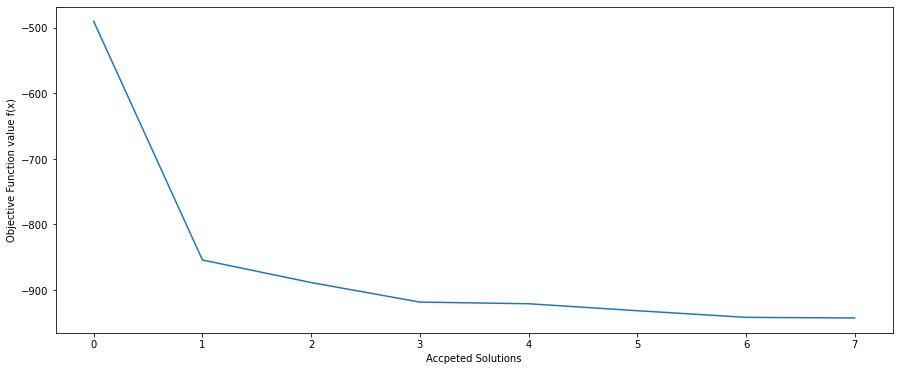

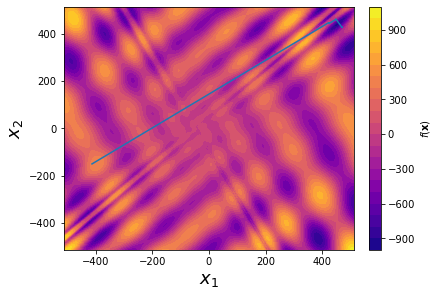

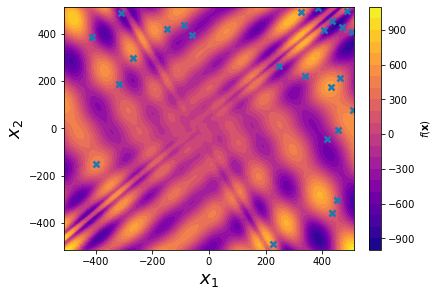

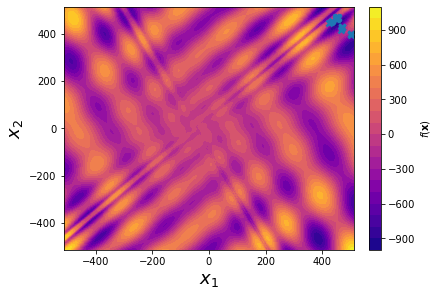

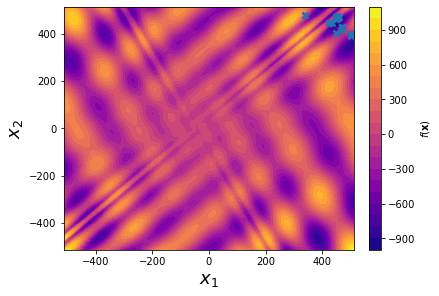

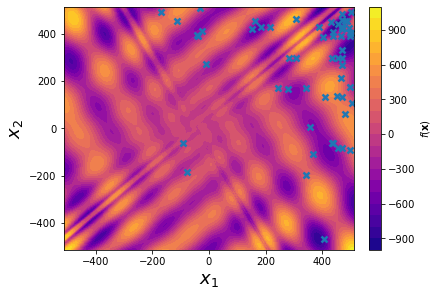

In [1027]:
plt.figure(figsize = (15,6))
plt.plot(f_sol, '-')
# plt.title('Objective Function f(x) for new solutions')
plt.ylabel('Objective Function value f(x)');plt.xlabel('Accpeted Solutions')
plt.show()

if DIM == 2:
    plot_walk(f_eval_plot, x_sol, num)
    plot_points(f_eval_plot, diss_archive_x, num,diss_archive_f)
    plot_points(f_eval_plot, best_archive_x, num,best_archive_f)
    plot_points(f_eval_plot, x_hist, num,best_archive_f)
    plot_points(f_eval_plot, xs, num,best_archive_f)


In [568]:
%%timeit
SELECTION_TYPE = 'Simple_roulette'
BREEDING_TYPE = 'Simple'
bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga()

29 s ± 453 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [569]:
%%timeit
SELECTION_TYPE = 'Simple_roulette'
BREEDING_TYPE = 'Cavicchio'
bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga()

28 s ± 205 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [570]:
%%timeit
SELECTION_TYPE = 'SRSWR'
BREEDING_TYPE = 'Simple'
bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga()

27.7 s ± 308 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [571]:
%%timeit
SELECTION_TYPE = 'SRSWR'
BREEDING_TYPE = 'Cavicchio'
bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga()

27.3 s ± 90.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [572]:
%%timeit
SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Simple'
bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga()

27.4 s ± 250 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [573]:
%%timeit
SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Cavicchio'
bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga()

27.2 s ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [483]:
SELECTION_TYPE = 'Simple_roulette'
BREEDING_TYPE = 'Simple'
DIM = 6
total = []
num = 15
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
    total.append(bestf)
print('Simple/Simple: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

SELECTION_TYPE = 'Simple_roulette'
BREEDING_TYPE = 'Cavicchio'
DIM = 6
total = []
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
    total.append(bestf)
print('Simple/Cavicchio: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

SELECTION_TYPE = 'SRSWR'
BREEDING_TYPE = 'Simple'
DIM = 6
total = []
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
    total.append(bestf)
print('SRSWR/Simple: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

SELECTION_TYPE = 'SRSWR'
BREEDING_TYPE = 'Cavicchio'
DIM = 6
total = []
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
    total.append(bestf)
print('SRSWR/Cavicchio: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Simple'
DIM = 6
total = []
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
    total.append(bestf)
print('Tournament/Simple: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Cavicchio'
DIM = 6
total = []
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
    total.append(bestf)
print('Tournament/Cavicchio: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))


Simple/Simple: mean - -3491.996105497811, std - 158.8152470840376, highlow - 624.1263515640976
Simple/Cavicchio: mean - -3481.1624682753404, std - 149.61831799707753, highlow - 530.0134302631786
SRSWR/Simple: mean - -3626.2334533255766, std - 124.2360640695847, highlow - 455.2073024220126
SRSWR/Cavicchio: mean - -3588.5341187582662, std - 170.46355227239215, highlow - 625.7649333267195
Tournament/Simple: mean - -4155.310307687005, std - 83.07020456396658, highlow - 351.82155946982175
Tournament/Cavicchio: mean - -4078.621295176504, std - 103.40203225273405, highlow - 384.65828854021765


In [706]:
SELECTION_TYPE = 'Simple_roulette'
BREEDING_TYPE = 'Simple'
DIM = 6
total = []
num = 25
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
    total.append(bestf)
print('Simple/Simple: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

SELECTION_TYPE = 'Simple_roulette'
BREEDING_TYPE = 'Cavicchio'
DIM = 6
total = []
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
    total.append(bestf)
print('Simple/Cavicchio: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

SELECTION_TYPE = 'SRSWR'
BREEDING_TYPE = 'Simple'
DIM = 6
total = []
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
    total.append(bestf)
print('SRSWR/Simple: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

SELECTION_TYPE = 'SRSWR'
BREEDING_TYPE = 'Cavicchio'
DIM = 6
total = []
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
    total.append(bestf)
print('SRSWR/Cavicchio: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Simple'
DIM = 6
total = []
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
    total.append(bestf)
print('Tournament/Simple: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Cavicchio'
DIM = 6
total = []
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
    total.append(bestf)
print('Tournament/Cavicchio: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))


Simple/Simple: mean - -3027.345587579006, std - 216.68787616234226, highlow - 850.0307254835898
Simple/Cavicchio: mean - -3026.5823777498545, std - 213.7964383329838, highlow - 875.7266252769987
SRSWR/Simple: mean - -3112.7161067112347, std - 206.78933474025, highlow - 832.1076195868809
SRSWR/Cavicchio: mean - -3138.6490463749583, std - 197.93375245212442, highlow - 789.182723765397
Tournament/Simple: mean - -3811.2706555713535, std - 195.51148506528287, highlow - 832.3265326894671
Tournament/Cavicchio: mean - -3758.585121041074, std - 217.5364631240631, highlow - 852.875524844615


In [983]:
MUTATION_TYPE = 'SA_like'
SELECTION_TYPE = 'Simple_roulette'
BREEDING_TYPE = 'Simple'
DIM = 6
total = []
num = 25
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f,a = ga(seed = i)
    total.append(bestf)
print('Simple/Simple: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

SELECTION_TYPE = 'Simple_roulette'
BREEDING_TYPE = 'Cavicchio'
DIM = 6
total = []
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f,ax1 = ga(seed = i)
    total.append(bestf)
print('Simple/Cavicchio: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

SELECTION_TYPE = 'SRSWR'
BREEDING_TYPE = 'Simple'
DIM = 6
total = []
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f,a = ga(seed = i)
    total.append(bestf)
print('SRSWR/Simple: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

SELECTION_TYPE = 'SRSWR'
BREEDING_TYPE = 'Cavicchio'
DIM = 6
total = []
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f,a = ga(seed = i)
    total.append(bestf)
print('SRSWR/Cavicchio: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Simple'
DIM = 6
total = []
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f,a = ga(seed = i)
    total.append(bestf)
print('Tournament/Simple: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Cavicchio'
DIM = 6
total = []
for i in range(num):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f,a = ga(seed = i)
    total.append(bestf)
print('Tournament/Cavicchio: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))


Simple/Simple: mean - -2941.4393009061046, std - 174.305165816467, highlow - 620.882476843306
Simple/Cavicchio: mean - -2892.165792611586, std - 255.10709461759282, highlow - 1180.1353470093122
SRSWR/Simple: mean - -3390.9097182733067, std - 225.45043010132179, highlow - 857.1907585713398
SRSWR/Cavicchio: mean - -3353.094732718409, std - 231.04093195670464, highlow - 1119.3053455851532
Tournament/Simple: mean - -3928.2269756098367, std - 342.6352680455723, highlow - 1398.755120949233
Tournament/Cavicchio: mean - -3951.650340225213, std - 300.02215044263136, highlow - 1142.980926340796


In [713]:
num = 25
POP_SIZE = 30
P_MUTATION = 0.1
P_CROSSOVER = 0.95
SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Simple'
DIM = 6
popsizes = np.linspace(30,100,10)
results = []
for popsize in popsizes:
    total = []
    if int(popsize) % 2 == 1:
        POP_SIZE = int(popsize) + 1
    else:
        POP_SIZE = int(popsize)
    for i in range(num):
        bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
        total.append(bestf)
    results.append([np.mean(total),np.std(total), np.max(total)-np.min(total)])

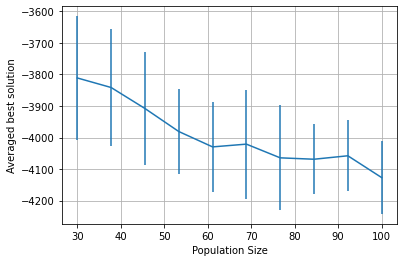

In [714]:
results = np.array(results)
plt.errorbar(popsizes, results[:,0], yerr=results[:,1])
plt.xlabel('Population Size');plt.ylabel('Averaged best solution');plt.grid()
plt.show()

In [722]:
num = 25
POP_SIZE = 30
P_MUTATION = 0.1
P_CROSSOVER = 0.95
SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Simple'
DIM = 6
popsizes = np.linspace(30,100,10)
results = []
for popsize in popsizes:
    total = []
    if int(popsize) % 2 == 1:
        POP_SIZE = int(popsize) + 1
        FUNC_EVAL_LIM = 750 * 30/POP_SIZE
    else:
        POP_SIZE = int(popsize)
        FUNC_EVAL_LIM = 750 * 30/POP_SIZE
    for i in range(num):
        bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
        total.append(bestf)
    results.append([np.mean(total),np.std(total), np.max(total)-np.min(total)])

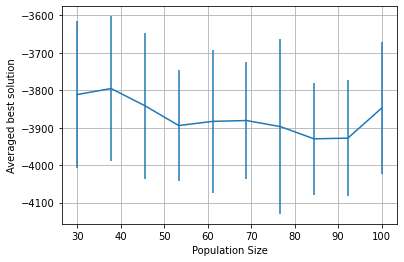

In [723]:
results = np.array(results)
plt.errorbar(popsizes, results[:,0], yerr=results[:,1])
plt.xlabel('Population Size');plt.ylabel('Averaged best solution');plt.grid()
plt.show()

In [715]:
num = 25
POP_SIZE = 30
P_MUTATION = 0.1
P_CROSSOVER = 0.95
SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Simple'
DIM = 6
pcs = np.linspace(0.75,1,10)
results = []
for pc in pcs:
    total = []
    P_CROSSOVER = pc
    for i in range(num):
        bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
        total.append(bestf)
    results.append([np.mean(total),np.std(total), np.max(total)-np.min(total)])

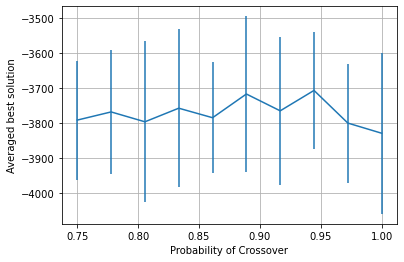

In [716]:
results = np.array(results)
plt.errorbar(pcs, results[:,0], yerr=results[:,1])
plt.xlabel('Probability of Crossover');plt.ylabel('Averaged best solution');plt.grid()
plt.show()

In [708]:
num = 25
POP_SIZE = 30
P_MUTATION = 0.1
P_CROSSOVER = 0.95
SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Simple'
DIM = 6
pms = np.logspace(-1,-3,10)
results = []
for pm in pms:
    total = []
    P_MUTATION = pm
    for i in range(num):
        bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
        total.append(bestf)
    results.append([np.mean(total),np.std(total), np.max(total)-np.min(total)])

Breaking out at iteration 93
Breaking out at iteration 423
Breaking out at iteration 218
Breaking out at iteration 366
Breaking out at iteration 159
Breaking out at iteration 230
Breaking out at iteration 656
Breaking out at iteration 84
Breaking out at iteration 83
Breaking out at iteration 90
Breaking out at iteration 172
Breaking out at iteration 634
Breaking out at iteration 398
Breaking out at iteration 73
Breaking out at iteration 140
Breaking out at iteration 632
Breaking out at iteration 62
Breaking out at iteration 555
Breaking out at iteration 392
Breaking out at iteration 145
Breaking out at iteration 578
Breaking out at iteration 99
Breaking out at iteration 29
Breaking out at iteration 51
Breaking out at iteration 68
Breaking out at iteration 34
Breaking out at iteration 55
Breaking out at iteration 59
Breaking out at iteration 301
Breaking out at iteration 58
Breaking out at iteration 36
Breaking out at iteration 98
Breaking out at iteration 43
Breaking out at iteration 6

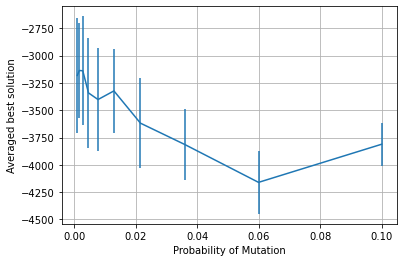

In [709]:
results = np.array(results)
plt.errorbar(pms, results[:,0], yerr=results[:,1])
plt.xlabel('Probability of Mutation');plt.ylabel('Averaged best solution');plt.grid()
plt.show()

In [731]:
num = 15
POP_SIZE = 30
P_MUTATION = 0.1
P_CROSSOVER = 0.95
SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Simple'
DIM = 6
groupsizes = np.arange(4,30,2)
results = []
for groupsize in groupsizes:
    total = []
    TOURNAMENT_GROUP_SIZE = groupsize
    for i in range(num):
        bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = i)
        total.append(bestf)
    results.append([np.mean(total),np.std(total), np.max(total)-np.min(total)])

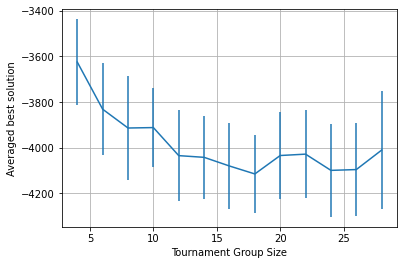

In [732]:
results = np.array(results)
plt.errorbar(groupsizes, results[:,0], yerr=results[:,1])
plt.xlabel('Tournament Group Size');plt.ylabel('Averaged best solution');plt.grid()
plt.show()

In [849]:
groupsizes

array([ 4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28])

In [850]:
num = 15
POP_SIZE = 30
P_MUTATION = 0.1
P_CROSSOVER = 0.95
SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Simple'
DIM = 6
popsizes = np.linspace(30,100,13)
xx1, xx2 = np.meshgrid(popsizes,groupsizes)
f_eval = np.zeros([len(xx1),len(xx2)])
results = []
for i in range(len(popsizes)):
    for j in range(len(groupsizes)):
        if int(popsizes[i]) % 2 == 1:
            POP_SIZE = int(popsizes[i]) + 1
            FUNC_EVAL_LIM = 750 * 30/POP_SIZE
        else:
            POP_SIZE = int(popsizes[i])
            FUNC_EVAL_LIM = 750 * 30/POP_SIZE
        TOURNAMENT_GROUP_SIZE = groupsizes[j]
        total = []
        for k in range(num):
            bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = k)
            total.append(bestf)
        f_eval[i][j] = np.mean(total)

Text(0, 0.5, '$f(\\mathbf{x})$')

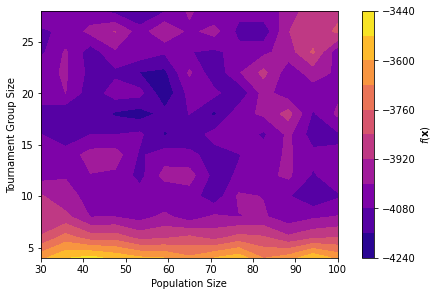

In [869]:
fig1, ax1 = plt.subplots(constrained_layout=True)
CS = ax1.contourf(xx1, xx2, f_eval.T, 10, cmap=cm.plasma)

ax1.set_xlabel('Population Size')
ax1.set_ylabel('Tournament Group Size')

cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('$f(\mathbf{x})$')

In [874]:
min = np.inf
for i in range(len(f_eval)):
    for j in range(len(f_eval[i])):
        if f_eval[i][j] < min:
            min = f_eval[i][j]
            loc = [i,j]
print(popsizes[loc[0]], groupsizes[loc[1]], min)

59.166666666666664 20 -4222.451074571391


In [875]:
num = 15
POP_SIZE = 60
P_MUTATION = 0.1
P_CROSSOVER = 0.95
TOURNAMENT_GROUP_SIZE = 20
FUNC_EVAL_LIM = 750 * 30 / POP_SIZE
SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Simple'
DIM = 6
pms = np.linspace(0.01,0.2,10)
pcs = np.linspace(0.85, 1, 10)
xx1, xx2 = np.meshgrid(pms,pcs)
f_eval = np.zeros([len(xx1),len(xx2)])
results = []
for i in range(len(pms)):
    for j in range(len(pcs)):
        P_MUTATION = pms[i]
        P_CROSSOVER = pcs[j]
        total = []
        for k in range(num):
            bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f = ga(seed = k)
            total.append(bestf)
        f_eval[i][j] = np.mean(total)

0.09444444444444444 0.8833333333333333 -4189.803487188373


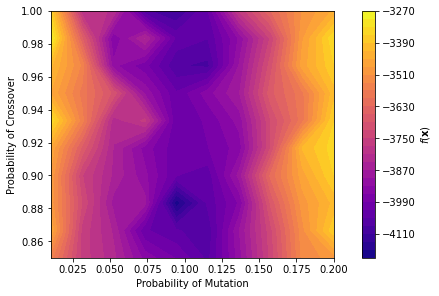

In [876]:
fig1, ax1 = plt.subplots(constrained_layout=True)
CS = ax1.contourf(xx1, xx2, f_eval.T, 30, cmap=cm.plasma)

ax1.set_xlabel('Probability of Mutation')
ax1.set_ylabel('Probability of Crossover')

cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('$f(\mathbf{x})$')

min = np.inf
for i in range(len(f_eval)):
    for j in range(len(f_eval[i])):
        if f_eval[i][j] < min:
            min = f_eval[i][j]
            loc = [i,j]
print(pms[loc[0]], pcs[loc[1]], min)

In [987]:
num = 15
POP_SIZE = 60
P_MUTATION = 0.1
P_CROSSOVER = 0.95
TOURNAMENT_GROUP_SIZE = 20
FUNC_EVAL_LIM = 750 * 30 / POP_SIZE
SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Simple'
MUTATION_TYPE = 'SA_like'
DIM = 6
startingts = np.linspace(0.05,0.25,10)
lks = np.linspace(20, 150, 10)
xx1, xx2 = np.meshgrid(startingts,lks)
f_eval = np.zeros([len(xx1),len(xx2)])
results = []
for i in range(len(startingts)):
    for j in range(len(lks)):
        STARTING_T = startingts[i]
        L_K = lks[j]
        total = []
        for k in range(num):
            bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f,a = ga(seed = k)
            total.append(bestf)
        f_eval[i][j] = np.mean(total)

0.2277777777777778 20.0 -4231.250602559627


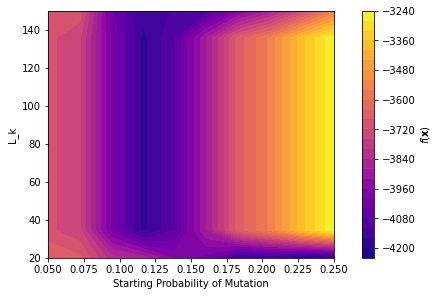

In [988]:
fig1, ax1 = plt.subplots(constrained_layout=True)
CS = ax1.contourf(xx1, xx2, f_eval.T, 30, cmap=cm.plasma)

ax1.set_xlabel('Starting Probability of Mutation')
ax1.set_ylabel('L_k')

cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('$f(\mathbf{x})$')

min = np.inf
for i in range(len(f_eval)):
    for j in range(len(f_eval[i])):
        if f_eval[i][j] < min:
            min = f_eval[i][j]
            loc = [i,j]
print(startingts[loc[0]], lks[loc[1]], min)

In [990]:
num = 25
POP_SIZE = 60
P_MUTATION = 0.1
STARTING_T = 0.2278
L_K = 20
P_CROSSOVER = 0.95
TOURNAMENT_GROUP_SIZE = 20
FUNC_EVAL_LIM = 750 * 30 / POP_SIZE
SELECTION_TYPE = 'Tournament'
BREEDING_TYPE = 'Simple'
MUTATION_TYPE = 'SA_like'

DIM = 6
pcs = np.linspace(0.75,1,10)
results = []
for pc in pcs:
    total = []
    P_CROSSOVER = pc
    for i in range(num):
        bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f,a = ga(seed = i)
        total.append(bestf)
    results.append([np.mean(total),np.std(total), np.max(total)-np.min(total)])

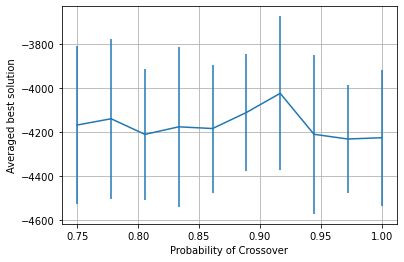

0.9722222222222222

In [995]:
results = np.array(results)
plt.errorbar(pcs, results[:,0], yerr=results[:,1])
plt.xlabel('Probability of Crossover');plt.ylabel('Averaged best solution');plt.grid()
plt.show()
pcs[-2]

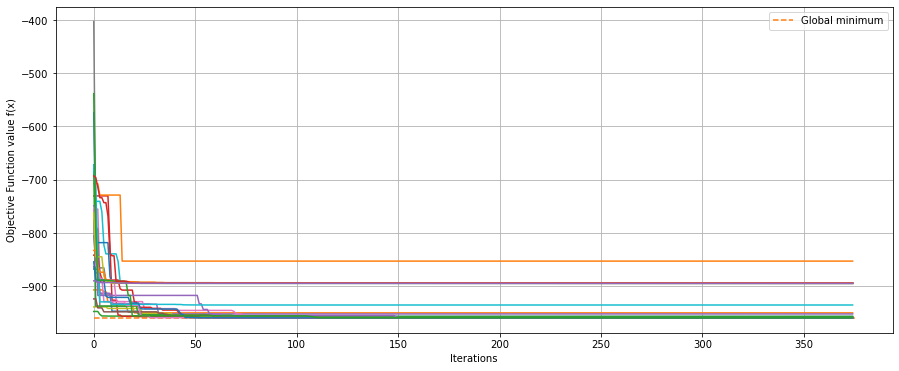

In [998]:
DIM = 2
POP_SIZE = 60
TOURNAMENT_GROUP_SIZE = 20
P_MUTATION = 0.0944
P_CROSSOVER = 0.972222
FUNC_EVAL_LIM = 750 * 30/POP_SIZE
MUTATION_TYPE = 'SA_like'
L_K = 20
STARTING_T = 0.2278
plt.figure(figsize = (15,6))
for j in range(25):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, a = ga(seed = j)
    f_plot = []
    min = np.inf
    for i in range(len(f_hist)):
        if f_hist[i] < min:
            min = f_hist[i]
            f_plot.append(min)
        else:
            f_plot.append(min)
    plt.plot(f_plot, '-', color = 'C{}'.format(j))
plt.ylabel('Objective Function value f(x)');plt.xlabel('Iterations')
plt.hlines(-959.6407,  0, FUNC_EVAL_LIM, linestyles = 'dashed', color = 'C1', label = 'Global minimum')
plt.legend();plt.grid()
plt.show()

No handles with labels found to put in legend.


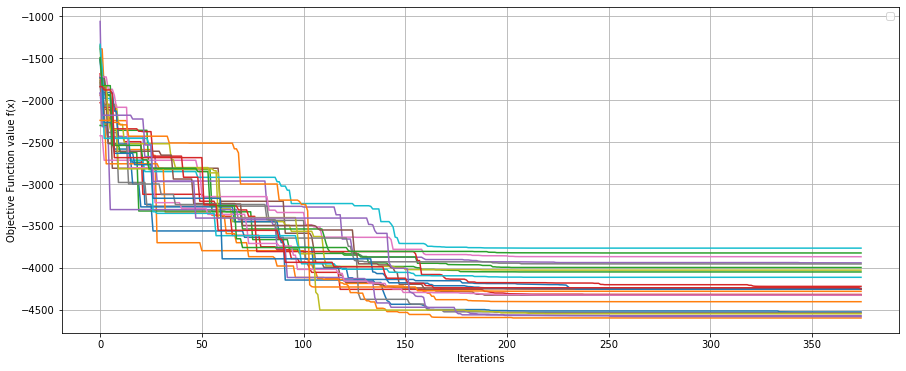

(-4230.568337909266, 247.63363981542165, 832.6304567532352)

In [996]:
DIM = 6
POP_SIZE = 60
TOURNAMENT_GROUP_SIZE = 20
P_MUTATION = 0.0944
P_CROSSOVER = 0.972222
FUNC_EVAL_LIM = 750 * 30/POP_SIZE
MUTATION_TYPE = 'SA_like'
L_K = 20
STARTING_T = 0.2278
total = []
plt.figure(figsize = (15,6))
for j in range(25):
    bestx, bestf, avg_fitness, x_hist, f_hist, x_sol, f_sol, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, a = ga(seed = j)
    f_plot = []
    total.append(bestf)
    min = np.inf
    for i in range(len(f_hist)):
        if f_hist[i] < min:
            min = f_hist[i]
            f_plot.append(min)
        else:
            f_plot.append(min)
    plt.plot(f_plot, '-', color = 'C{}'.format(j))
plt.ylabel('Objective Function value f(x)');plt.xlabel('Iterations')
plt.legend();plt.grid()
plt.show()
np.mean(total), np.std(total), np.max(total)-np.min(total)